In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import linregress

import warnings
warnings.filterwarnings('ignore')

In [2]:
ads = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/20.Ads/ad_table.csv', parse_dates=['date'])
ads.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


In [3]:
ads['date'] = pd.to_datetime(ads['date'])
ads = ads.sort_values(by=['ad', 'date'])

In [4]:
ads.dtypes

date                  datetime64[ns]
shown                          int64
clicked                        int64
converted                      int64
avg_cost_per_click           float64
total_revenue                float64
ad                            object
dtype: object

In [5]:
ads_cleaned = ads[(ads['shown'] > 0) & (ads['clicked'] > 0) & (ads['total_revenue'] >= 0)]

ads_cleaned.describe()

,shown,clicked,converted,avg_cost_per_click,total_revenue
count,2091.000000,2091.000000,2091.000000,2091.000000,2091.000000
mean,68853.852702,3088.744142,127.822573,1.387661,1989.242257
std,48799.535713,3792.468317,234.394500,0.746035,3958.838731
min,7494.000000,187.000000,0.000000,0.080000,0.000000
25%,28446.000000,756.500000,18.000000,0.780000,244.765000
50%,54569.000000,1413.000000,42.000000,1.410000,561.070000
75%,100395.500000,3413.500000,106.000000,1.920000,1634.895000
max,192507.000000,20848.000000,1578.000000,4.190000,39623.710000


In [6]:
ads_cleaned.isnull().sum()

date                  0
shown                 0
clicked               0
converted             0
avg_cost_per_click    0
total_revenue         0
ad                    0
dtype: int64

In [7]:
ads_cleaned['date'].value_counts()

2015-10-01    40
2015-10-20    40
2015-10-22    40
2015-10-23    40
2015-10-24    40
2015-10-30    40
2015-10-31    40
2015-11-02    40
2015-11-03    40
2015-11-06    40
2015-11-08    40
2015-11-09    40
2015-11-10    40
2015-11-13    40
2015-11-14    40
2015-11-16    40
2015-11-17    40
2015-10-21    40
2015-10-27    40
2015-10-10    40
2015-10-13    40
2015-10-04    40
2015-10-05    40
2015-10-06    40
2015-10-08    40
2015-10-18    40
2015-10-11    40
2015-11-22    40
2015-10-17    40
2015-10-15    40
2015-10-29    39
2015-10-25    39
2015-11-21    39
2015-11-20    39
2015-11-18    39
2015-10-03    39
2015-10-16    39
2015-11-12    39
2015-10-14    39
2015-10-07    39
2015-10-09    39
2015-11-07    39
2015-11-05    39
2015-10-12    39
2015-11-01    39
2015-10-28    39
2015-10-19    39
2015-11-11    38
2015-10-26    38
2015-11-15    38
2015-11-04    38
2015-10-02    38
2015-11-19    38
Name: date, dtype: int64

### Question 1
If you had to identify the 5 best ad groups, which ones would they be? Which metric did you choose to identify the best ad groups? Why? Explain the pros of your metric as well as the possible cons.

Here the goal is to choose the best 5 ads based on the provided data. We plan on using average return on advertising budget as a metric to choose the top ad campaigns.

In [8]:
best_ads_avg_revenue = ads_cleaned.groupby('ad').apply(lambda x: pd.Series({
'avg_return': x['total_revenue'].sum() / (x['clicked'].sum() * x['avg_cost_per_click'].mean())
})).reset_index().sort_values(by='avg_return', ascending=False)

best_ads_avg_revenue.head(5)

,ad,avg_return
24,ad_group_31,8.591346
11,ad_group_2,2.392715
7,ad_group_16,2.378300
5,ad_group_14,1.785444
19,ad_group_27,1.262210


The problem with using average return as a metric is, it does not identify the ads with low average return but are consistently trending up. Arguably, the ads that are trending up are equally important to marketing teams, if not more, than the ones with high average return and trending down. So, it makes sense to look both the average return and the trend to know the complete story.

In [9]:
def slope_trendline(y, x):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

In [10]:
def slope_p_value(y, x):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return p_value

In [11]:
best_ads = ads_cleaned.groupby('ad').apply(lambda x: pd.Series({
'trend': slope_trendline(x['total_revenue'] / (x['clicked'] * x['avg_cost_per_click']), x['date'].apply(lambda x: x.toordinal())),
})).reset_index().merge(best_ads_avg_revenue, on='ad').sort_values(by='avg_return', ascending=False)

print(best_ads.head(5))

             ad     trend  avg_return
24  ad_group_31  0.022719    8.591346
11   ad_group_2 -0.001403    2.392715
7   ad_group_16 -0.010152    2.378300
5   ad_group_14  0.006619    1.785444
19  ad_group_27  0.003469    1.262210


All the top 5 ad campaigns by average return are making money (return > 1). Among them, The ad groups 31, 14 and 27 are having a positive trend. While groups 2 and 16 have high average return but are trending down.

### Question 2

For each group, predict how many ads will be shown on Dec, 15 (assume each ad group keeps following its trend).

Here the goal is to predict how many times the ad will be shown on a future date.

The simplest method is to fit a straight line that is closest to the data points for each ad group and use it to predict future views.

Let's pick few arbitrary videos and visualize the time series of views.

In [12]:
ads_group_31 = ads_cleaned[ads_cleaned['ad'] == "ad_group_31"]

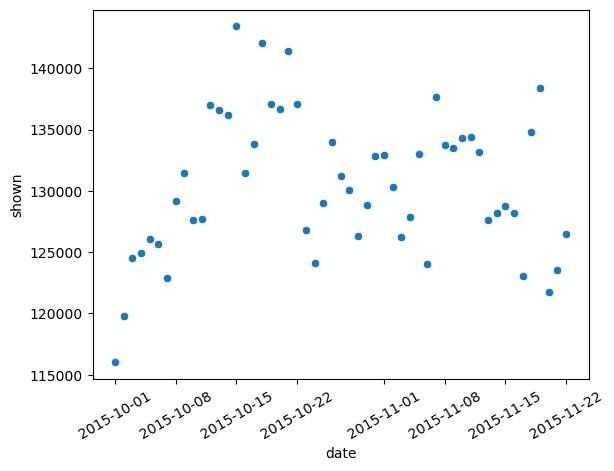

In [13]:
ax = sns.scatterplot(x='date', y='shown', data=ads_group_31)
ax.tick_params(axis='x', rotation=30)

In [14]:
ads_group_38 = ads_cleaned[ads_cleaned['ad'] == "ad_group_38"]

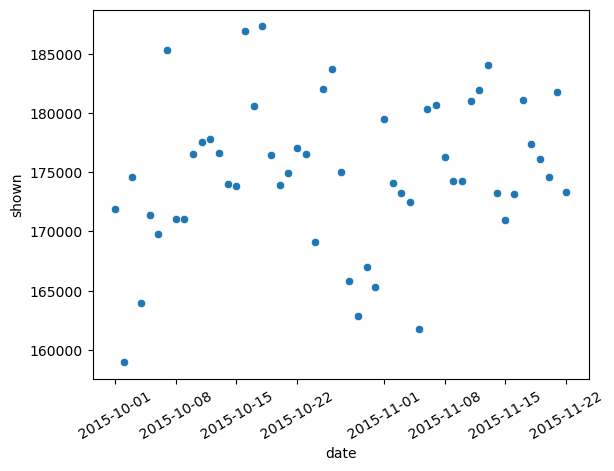

In [15]:
ax = sns.scatterplot(x='date', y='shown', data=ads_group_38)
ax.tick_params(axis='x', rotation=30)

Fitting a line to time series of all the ad campaigns

In [16]:
unique_ads = ads_cleaned['ad'].unique()
new = pd.DataFrame({'x': pd.to_datetime("2015-12-15")}, index=[0])
prediction = pd.DataFrame(columns=['ad', 'prediction'])

In [17]:
for i in unique_ads:
    x = pd.to_numeric(ads_cleaned[ads_cleaned['ad'] == i]['date'])
    y = ads_cleaned[ads_cleaned['ad'] == i]['shown']
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(x.values.reshape(-1, 1), y)
    predicted = round(model.predict(pd.to_numeric(new['x']).values.reshape(-1, 1))[0], 0)
    predicted_df = pd.DataFrame({'ad': [i], 'prediction': [predicted]})
    prediction = pd.concat([prediction, predicted_df])

print(prediction.head())

            ad  prediction
0   ad_group_1     74777.0
0  ad_group_10    120999.0
0  ad_group_11     20259.0
0  ad_group_12     29137.0
0  ad_group_13    164775.0


### Question 3
Cluster ads into 3 groups: the ones whose avg_cost_per_click is going up, the ones whose avg_cost_per_click is flat and the ones whose avg_cost_per_click is going down.

In [18]:
ads.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


In [19]:
trend_ads = ads_cleaned.groupby('ad').apply(lambda x: pd.Series({
'trend': slope_trendline(x['avg_cost_per_click'], x['date'].apply(lambda x: x.toordinal())),
})).reset_index().sort_values(by='trend', ascending=False)

trend_ads

,ad,trend
25,ad_group_32,0.004258
30,ad_group_37,0.002610
22,ad_group_3,0.002445
34,ad_group_40,0.001925
32,ad_group_39,0.001141
0,ad_group_1,0.000926
3,ad_group_12,0.000861
18,ad_group_26,0.000724
12,ad_group_20,0.000685
9,ad_group_18,0.000625
